<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Word2Vec-embedding-gensim" data-toc-modified-id="Word2Vec-embedding-gensim-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Word2Vec embedding gensim</a></span></li><li><span><a href="#tf-idf" data-toc-modified-id="tf-idf-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>tf-idf</a></span></li><li><span><a href="#TODO:-Compare-the-answer-similarities-to-the" data-toc-modified-id="TODO:-Compare-the-answer-similarities-to-the-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>TODO: Compare the answer similarities to the</a></span></li></ul></div>

In [66]:
# import basic libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
stemmer = PorterStemmer()
import os
# load the word2vec algorithm from the gensim library
from gensim.models import word2vec

from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors
from gensim.models import Word2Vec, KeyedVectors 
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial import distance

import itertools

In [3]:
import  multiprocessing 
multiprocessing.cpu_count() 

4

In [4]:
import torch

torch.cuda.get_device_name()

'GeForce GTX 950M'

# Word2Vec embedding gensim

In [5]:
# load dataframes
l2q = pd.read_csv('l2q.csv', index_col=0)
l2a = pd.read_csv('l2a.csv', index_col=0)

In [181]:
# function to clean text
def process_words(raw_review):
    
    # 1. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", raw_review) 
    
    # 2. Convert to lower case, split into individual words
    words = letters_only.lower().split()
    
    # 3. Remove Stopwords. In Python, searching a set is much faster than searching a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    
    # 4. Remove stop words
    meaningful_words = [w for w in words if not w in stops]  #returns a list 

    # 5. Stem words. Need to define porter stemmer above
    meaningful_words = [stemmer.stem(word) for word in meaningful_words]
    
    # 6. Join the words back into one string separated by space, and return the result.
    return( " ".join( meaningful_words ))

In [7]:

# build a corpus for the word2vec model
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for sentence in data:
        word_list = sentence.split(" ")
        corpus.append(word_list)    
           
    return corpus

In [8]:
# Process the answers
processed_questions = [process_words(text) for text in l2q['questions_text']]

In [9]:
 l2q['questions_text'][0]

'What Does Medicare IME Stand For ?'

In [10]:
processed_questions[0]

'medicare ime stand'

In [11]:
# Build the corpus: transform sentences to list of words
corpus = build_corpus(processed_questions)
# Create word2vec embedding
w2v_embedding_q = word2vec.Word2Vec(corpus, size=100, window=5, min_count=50,workers=4)

In [12]:
# The most important 10 words 
print("The most important 10 words", w2v_embedding_q.wv.index2word[:10])

The most important 10 words ['insurance', 'life', 'health', 'cover', 'medicare', 'get', 'term', 'much', 'car', 'disability']


In [13]:
w2v_embedding_q.wv.most_similar('insurance')

[('claim', 0.6934787034988403),
 ('someone', 0.683912456035614),
 ('people', 0.6812896728515625),
 ('new', 0.6808490753173828),
 ('get', 0.6800342798233032),
 ('license', 0.6740952730178833),
 ('stay', 0.6711623668670654),
 ('would', 0.6711446046829224),
 ('parents', 0.670677900314331),
 ('companies', 0.6615357995033264)]

In [14]:
w2v_embedding_q.wv.most_similar('life')

[('policy', 0.8320557475090027),
 ('whole', 0.8139945864677429),
 ('cash', 0.7964382171630859),
 ('happens', 0.7951512336730957),
 ('owner', 0.7829078435897827),
 ('surrender', 0.7818723917007446),
 ('paid', 0.7752364277839661),
 ('value', 0.7686610221862793),
 ('mean', 0.7487317323684692),
 ('universal', 0.7485994100570679)]

In [15]:
# The less important 10 words 
print("The less important 10 words", w2v_embedding_q.wv.index2word[-10:])

The less important 10 words ['personal', 'dog', 'include', 'primary', 'paying', 'probate', 'broken', 'needs', 'individual', 'loss']


Extract the embedding weights from the gensim Word2Vec embedding layer and store it in a numpy array, ready for use in TensorFlow and Keras.

In [16]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

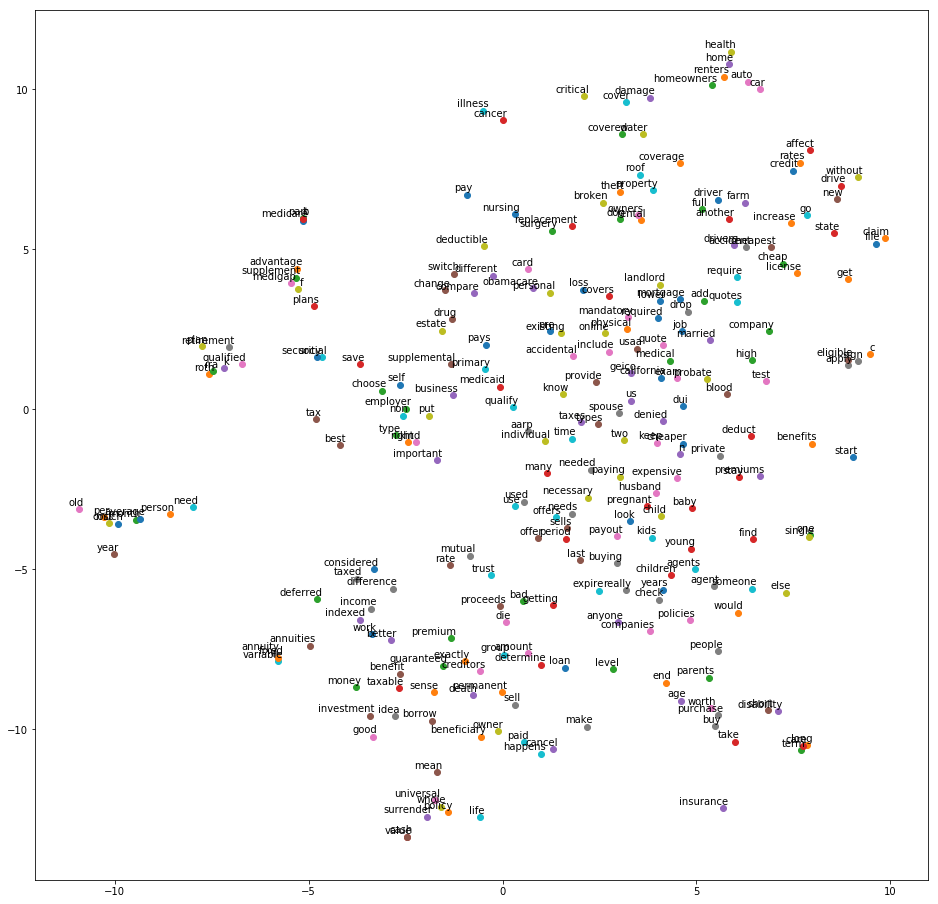

In [17]:
tsne_plot(w2v_embedding_q)

In [18]:
# convert the wv word vectors into a numpy matrix that is suitable for insertion
# into our TensorFlow and Keras models
def create_embedding_matrix(model, vector_dim = 100):
    embedding_matrix = np.zeros((len(model.wv.vocab), vector_dim ))
    for i in range(len(model.wv.vocab)):
        embedding_vector = model.wv[model.wv.index2word[i]]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [19]:
embedding_matrix_q = create_embedding_matrix(w2v_embedding_q)

In [20]:
def sentence_vector(model, sentence):
    sentence_vec = 0
    for w in sentence:  
        try :
            # Sum the word vetcors 
            sentence_vec += model.wv.get_vector(w)
        except:
            pass
    return sentence_vec

In [65]:
sentence_vector(w2v_embedding_q, corpus[0])

array([-0.18516709, -0.14277227, -0.03446399, -0.02351163,  0.1046887 ,
       -0.35691747, -0.05614672,  0.3396529 , -0.11943779, -0.28742906,
        0.20248125, -0.00557111,  0.04057985,  0.08642518, -0.6366735 ,
       -0.17305046, -0.01731722, -0.3970514 , -0.13089363,  0.06149254,
        0.29872602, -0.36453846,  0.05288077, -0.31482133, -0.28893614,
       -0.23721331, -0.06130653, -0.02132056, -0.21775201, -0.08202432,
       -0.3446024 , -0.19801448, -0.1574201 ,  0.11964632,  0.50044495,
       -0.08073939,  0.52833647, -0.01713642, -0.20684333,  0.14870557,
       -0.2134027 ,  0.20552899, -0.1002664 , -0.25160822,  0.1608286 ,
        0.8501775 ,  0.30984712,  0.3284868 ,  0.55378455,  0.53071827,
       -0.09967076,  0.30240282, -0.28486216, -0.14240319, -0.28011104,
       -0.13307695,  0.08176289,  0.10010695, -0.23079692,  0.3819641 ,
       -0.18849267, -0.40005225,  0.15747488, -0.19641687,  0.35555866,
       -0.27942944, -0.12108409, -0.02591861, -0.36897984,  0.20

# tf-idf

In [182]:
from sklearn.feature_extraction.text import TfidfVectorizer
import collections
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint
from sklearn.metrics.pairwise import cosine_similarity


def word_tokenizer(text):
    #tokenizes and stems the text
    tokens = word_tokenize(text)
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(t) for t in tokens if t not in stopwords.words('english')]
    return tokens

def construct_tfidf_matrix(sentences):
    tfidf_vectorizer = TfidfVectorizer(tokenizer=process_words,
                                    stop_words=stopwords.words('english'))

    #builds a tf-idf matrix for the sentences
    tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)
    similarity_matrix = cosine_similarity(tfidf_matrix)
    return similarity_matrix

In [183]:
similarity_matrix = construct_tfidf_matrix(list(l2q['questions_text'])) 

In [197]:
# To have to compute so it's saved
#np.save('similarity_matrix', similarity_matrix)

In [22]:
similarity_matrix = np.load('similarity_matrix.npy')

In [184]:
# Similarity matrix dataframe
sm_df = pd.DataFrame(similarity_matrix)

In [185]:
sm_df.head()

,0,1,2,3,4,5,6,7,8,9,...,27977,27978,27979,27980,27981,27982,27983,27984,27985,27986
0,1.000000,0.808125,0.509818,0.745176,0.745176,0.781229,0.599353,0.664041,0.617637,0.521068,...,0.591742,0.779237,0.779237,0.775923,0.401767,0.401767,0.697212,0.697212,0.744969,0.756248
1,0.808125,1.000000,0.556511,0.766952,0.766952,0.599130,0.636823,0.694813,0.665382,0.605080,...,0.742926,0.756141,0.756141,0.790007,0.422037,0.422037,0.614369,0.614369,0.867396,0.679639
2,0.509818,0.556511,1.000000,0.462911,0.462911,0.386143,0.762707,0.691842,0.643489,0.873299,...,0.812801,0.679464,0.679464,0.609179,0.702097,0.702097,0.770094,0.770094,0.621627,0.721506
3,0.745176,0.766952,0.462911,1.000000,1.000000,0.710860,0.661233,0.598979,0.550586,0.447860,...,0.668590,0.853057,0.853057,0.644146,0.397731,0.397731,0.597265,0.597265,0.745730,0.719564
4,0.745176,0.766952,0.462911,1.000000,1.000000,0.710860,0.661233,0.598979,0.550586,0.447860,...,0.668590,0.853057,0.853057,0.644146,0.397731,0.397731,0.597265,0.597265,0.745730,0.719564


In [272]:
# This function will return a matrix, each row contain a list of tuples
# the tuple contain the position and and the value of similarity between strings
def filter_threshold(matrix, threshold):
    similar = []
    for line_idx, row in enumerate(matrix):
        above_threshold = []
        for row_index, r in enumerate(row):
            if r>= threshold and row_index<=len(matrix)/2:
                above_threshold.append((line_idx,row_index,r))
        similar.append(above_threshold)
    return similar

In [ ]:
threshold = 0.95
# Filter up to a threshold
sm_th = filter_threshold(similarity_matrix,threshold)

In [ ]:
sm_th

Example randomly chosen!

In [208]:
# 3, 11258
l2q.iloc[6]['questions_text']

'Where To Get Homeowners Insurance ?'

In [209]:
l2q.iloc[18379]['questions_text']

'Why Homeowners Insurance Goes Up ?'

In [210]:
# Remove the rows with one eleme since it's the comparison with ot self
sm_th = [elem for elem in sm_th if len(elem)>1]
sm_th = list(itertools.chain(*sm_th))

In [246]:
# Create a dataframe for similar questions
similar_questions = pd.DataFrame({'index_1':[x[0] for x in sm_th ],'index_2':[x[1] for x in sm_th ],
                      'percentage_sim':[x[2] for x in sm_th ]})

In [247]:
# Remove the rows where we compare the same index
similar_questions = similar_questions[similar_questions['index_1'] != similar_questions['index_2']]

In [248]:
similar_questions.head(10)

,index_1,index_2,percentage_sim
1,0,883,0.952719
2,0,7844,0.952719
3,0,9501,0.951678
4,0,14136,0.962752
5,0,14137,0.962752
6,0,14138,0.962752
7,0,14731,0.978928
8,0,14732,0.978928
10,1,5523,0.975969
11,1,7182,0.984983


In [249]:
l2q.iloc[6]['questions_text']

'Where To Get Homeowners Insurance ?'

In [250]:
l2q.iloc[6547]['questions_text']

'What Is A Good Estimate For Homeowners Insurance ?'

In [251]:
l2q.iloc[7798]['questions_text']

'How Do I Get Homeowners Insurance ?'

In [252]:
# Merge the first question and it's answer
similar_questions = similar_questions.merge(l2q[['groundTruth_labels_x']], left_on='index_1', 
                right_index=True).rename(columns={'groundTruth_labels_x': 'index_1_answer'})

In [253]:
# Merge the second questions and it's answers
similar_questions = similar_questions.merge(l2q[['groundTruth_labels_x']], left_on='index_2',
                    right_index=True).rename(columns={'groundTruth_labels_x': 'index_2_answer'})

In [254]:
# Remove the new index 
similar_questions = similar_questions.reset_index().drop('index', axis=1)

In [255]:
similar_questions.head()

,index_1,index_2,percentage_sim,index_1_answer,index_2_answer
0,0,883,0.952719,16696,20109
1,7184,883,0.970429,9754,20109
2,7844,883,1.000000,8765,20109
3,13106,883,0.960136,8750,20109
4,13107,883,0.960136,9172,20109


Better rate when we used stemmer 

In [257]:
l2q.loc[0]['questions_text']

'What Does Medicare IME Stand For ?'

In [258]:
l2q.loc[883]['questions_text']

'Does Medicare Cost Money ?'

Similar questions but need different answers! Let's consider only rows where we had the same answers!

In [259]:
similar_answers = similar_questions[similar_questions['index_1_answer'] == similar_questions['index_2_answer']]

In [271]:
similar_answers.head()

,index_1,index_2,percentage_sim,index_1_answer,index_2_answer
491,22706,10852,1.0,2826,2826
518,22707,10854,1.0,21918,21918
1052,10852,22706,1.0,2826,2826
1067,10854,22707,1.0,21918,21918
19400,24870,21478,1.0,8978,8978


In [269]:
l2q.loc[27818]['questions_text']

'What Is Non-Participating Whole Life Insurance ?'

In [270]:
l2q.loc[13562]['questions_text']

'What Is Non Participating Whole Life Insurance ?'

In [261]:
similar_answers.describe()

,index_1,index_2,percentage_sim,index_1_answer,index_2_answer
count,626.000000,626.000000,626.000000,626.000000,626.000000
mean,13854.607029,13854.607029,0.985964,12812.894569,12812.894569
std,7869.657414,7869.657414,0.015823,8266.789943,8266.789943
min,124.000000,124.000000,0.950489,40.000000,40.000000
25%,7034.250000,7034.250000,0.972901,5351.000000,5351.000000
50%,13562.500000,13562.500000,0.992416,12234.000000,12234.000000
75%,20408.500000,20408.500000,1.000000,19813.000000,19813.000000
max,27978.000000,27978.000000,1.000000,27330.000000,27330.000000


In [262]:
# Keep only the one with percentage less than 1 since 1 is when the same questions in both index
similar_answers[similar_answers['percentage_sim'] <0.99]

,index_1,index_2,percentage_sim,index_1_answer,index_2_answer
25578,25764,17243,0.974129,24692,24692
25630,25765,17244,0.974129,24420,24420
26598,17243,25764,0.974129,24692,24692
26636,17244,25765,0.974129,24420,24420
35728,18652,17105,0.988234,2428,2428
39305,16970,503,0.970955,26100,26100
67734,1298,4146,0.969941,26724,26724
71975,1298,27568,0.981404,26724,26724
117886,18987,26920,0.964083,6642,6642
154203,8247,22383,0.984124,6926,6926


In [263]:
l2q.loc[25764]['questions_text']

'How Long Does It Usually Take To Get Life Insurance Money ?'

In [264]:
l2q.loc[17243]['questions_text']

'How Long Does It Take To Get Life Insurance Money ?'

# TODO: Compare the answer similarities to the 